In [ ]:
#import required libraries
import numpy as np
import torch
from torch import nn, optim
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms, models

In [ ]:
device = "cuda"
device

'cuda'

In [ ]:
#Data Preprocessing
imsize = 224
loader = transforms.Compose([
             transforms.Resize(imsize),
             transforms.ToTensor(),
             transforms.Normalize((0.485, 0.456, 0.406),
                                  (0.229, 0.224, 0.225))])

In [ ]:
def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image

In [ ]:
content_img = image_loader("dog.jpg").to(device)
style_img = image_loader("matisse.jpg").to(device)

In [ ]:
unloader = transforms.Compose([
               transforms.Normalize((-0.485/0.229,
                                     -0.456/0.224,
                                     -0.406/0.225),
                                     (1/0.229, 1/0.224, 1/0.225)),
               transforms.ToPILImage()])

In [ ]:
def tensor2image(tensor):
    image = tensor.to('cpu').clone()
    image = image.squeeze(0)
    image = unloader(image)
    return image

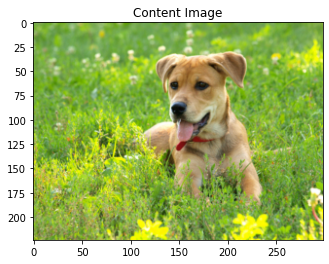

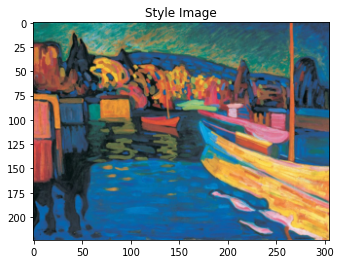

In [ ]:
plt.figure()
plt.imshow(tensor2image(content_img))
plt.title("Content Image")
plt.show()
plt.figure()
plt.imshow(tensor2image(style_img))
plt.title("Style Image")
plt.show()

In [ ]:
# Model Architecture
model = models.vgg19(pretrained=True).features

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


In [ ]:
for param in model.parameters():
    param.requires_grad_(False)

In [ ]:
model.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [ ]:
#Define relevant layers for feature extraction
relevant_layers = {'0': 'conv1_1', '5': 'conv2_1', '10':
                   'conv3_1', '19': 'conv4_1', '21': 'conv4_2',
                   '28': 'conv5_1'}

In [ ]:
def features_extractor(x, model, layers):
    """
      Extracts features from specified layers of a given model.

      Parameters:
      - x (torch.Tensor): Input tensor.
      - model (torch.nn.Module): Model from which features are extracted.
      - layers (dict): Dictionary mapping layer indices to layer names.

      Returns:
      - features (dict): Extracted features from specified layers.
    """
    features = {}
    for index, layer in model._modules.items():
        x = layer(x)
        if index in layers:
            features[layers[index]] = x
    return features

In [ ]:
# Extract content and style features
content_features = features_extractor(content_img, model,
                                      relevant_layers)
style_features = features_extractor(style_img, model,
                                    relevant_layers)

In [ ]:
# Compute Gram matrices for style features
style_grams = {}
for i in style_features:
    layer = style_features[i]
    _, d1, d2, d3 = layer.shape
    features = layer.view(d1, d2 * d3)
    gram = torch.mm(features, features.t())
    style_grams[i] = gram

In [ ]:
# Initialize target image for optimization
target_img = content_img.clone().requires_grad_(True).to(device)

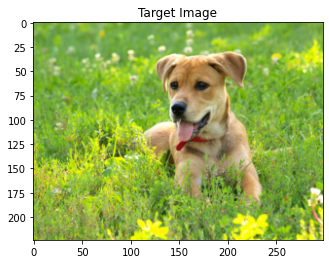

In [ ]:
plt.figure()
plt.imshow(tensor2image(target_img))
plt.title("Target Image")
plt.show()

In [ ]:
# Define style weights for each layer
style_weights = {'conv1_1': 1., 'conv2_1': 0.8, 'conv3_1': 0.6, 'conv4_1': 0.4, 'conv5_1': 0.2}

In [ ]:
# Set hyperparameters for the optimization process
alpha = 1  # Weight for content loss
beta = 1e5  # Weight for style loss
print_statement = 500  # Print losses and display the generated image every 'print_statement' iterations

In [ ]:
# Initialize Adam optimizer for updating the target image
optimizer = torch.optim.Adam([target_img], lr=0.001)

# Number of optimization iterations
iterations = 5000

Content loss:  0.0022951827850192785
Style_weights[conv1_1]:  1.0
Total loss:  46232896.0
1


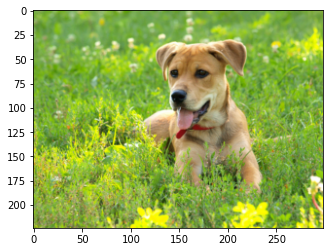

Content loss:  10.50124740600586
Style_weights[conv1_1]:  1.0
Total loss:  13877558.0
1


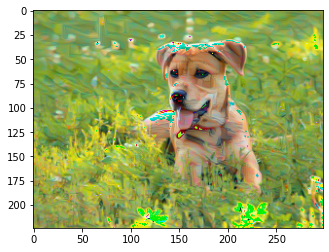

Content loss:  12.001189231872559
Style_weights[conv1_1]:  1.0
Total loss:  8878912.0
1


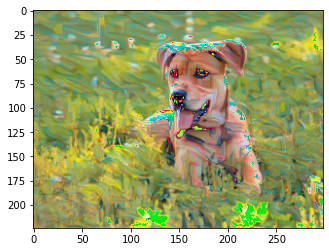

Content loss:  12.907876968383789
Style_weights[conv1_1]:  1.0
Total loss:  6663440.0
1


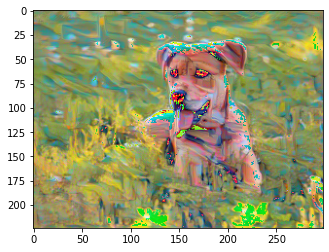

Content loss:  13.536864280700684
Style_weights[conv1_1]:  1.0
Total loss:  4608879.5
1


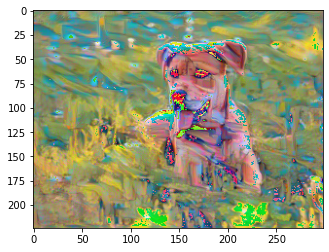

Content loss:  14.027475357055664
Style_weights[conv1_1]:  1.0
Total loss:  2273303.0
1


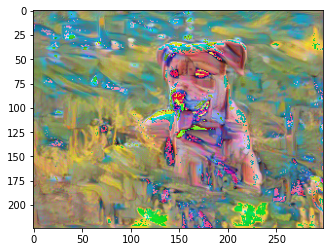

Content loss:  14.470903396606445
Style_weights[conv1_1]:  1.0
Total loss:  833523.375
1


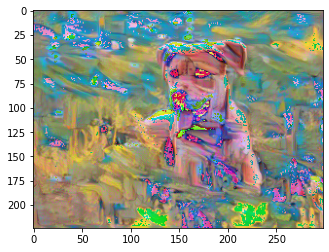

Content loss:  14.824939727783203
Style_weights[conv1_1]:  1.0
Total loss:  438483.21875
1


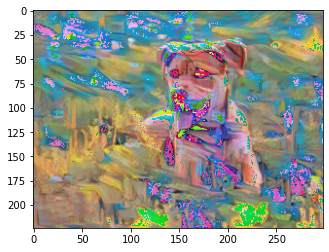

Content loss:  15.079082489013672
Style_weights[conv1_1]:  1.0
Total loss:  328438.09375
1


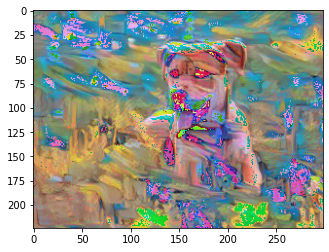

Content loss:  15.29086685180664
Style_weights[conv1_1]:  1.0
Total loss:  269855.375
1


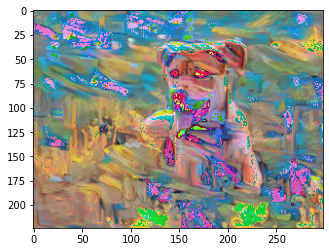

Content loss:  15.478975296020508
Style_weights[conv1_1]:  1.0
Total loss:  228335.171875
1


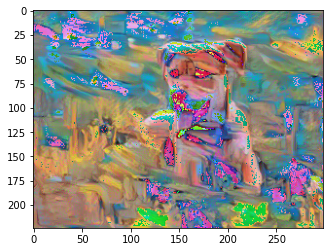

In [ ]:
# Optimization loop
for i in range(1, iterations+1):
    # Extract features from the current target image
    target_features = features_extractor(target_img, model, relevant_layers)

    # Calculate content loss
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)

    # Calculate style loss for each specified layer
    style_losses = 0
    for layer in style_weights:

        target_feature = target_features[layer]
        _, d1, d2, d3 = target_feature.shape

        # Reshape the target feature for Gram matrix calculation
        target_reshaped = target_feature.view(d1, d2 * d3)
        target_gram = torch.mm(target_reshaped, target_reshaped.t())
        style_gram = style_grams[layer]

        # Calculate style loss for the current layer
        style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        style_losses += style_loss / (d1 * d2 * d3)

    # Calculate total loss as a combination of content and style losses
    total_loss = alpha * content_loss + beta * style_losses

    # Perform optimization step
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    if  i % print_statement == 0 or i == 1:
        print('Content loss: ', content_loss.item())
        print('Style losses: ', style_losses.item())
        print('Total loss: ', total_loss.item())
        print(alpha)
        plt.imshow(tensor2image(target_img))
        plt.show()


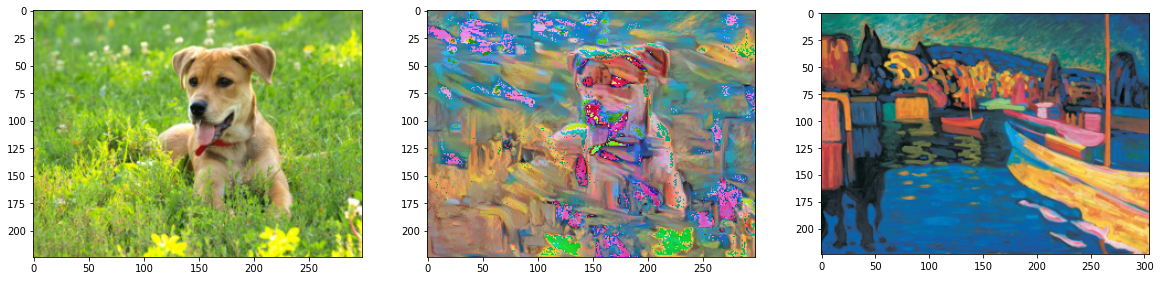

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 10))
ax1.imshow(tensor2image(content_img))
ax2.imshow(tensor2image(target_img))
ax3.imshow(tensor2image(style_img))
plt.show()

# Drawbacks and Possible Enhancements:

---


##Artifacts and Overfitting

Problem: When style transfer models are trained for a small number of iterations, they may produce artifacts. Another issue is overfitting to the input photos.

Improvement: To lessen overfitting, regularization strategies like dropout or introducing noise to the input image can be used. Increasing the number of iterations could also aid in improving the quality of the images that are produced.


##Just One Style Transfer

Problem: The reference image defines the style for which the submitted model is intended. Retraining or a more dynamic approach might be necessary to modify the model to accommodate different styles.

Improvement: Create a model that doesn't require retraining and can generalize across different styles. Think about applying models that facilitate conditional style transfer or style interpolation.

##Adjusting the Loss Function:

Problem: The current values of the loss function's weights (beta and alpha) are task-specific and may require careful tweaking.

Improvement: Perform a hyperparameter search to identify the ideal alpha and beta values. One can use methods such as random search or Bayesian optimization.